In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from feature_engine.datetime import DatetimeFeatures

%matplotlib inline

In [2]:
# add weather data
weather_data = pd.read_csv("data/DCweather_20210301_20230630.csv",
                      parse_dates=['datetime'],
                      index_col='datetime')
weather_data.drop(
    columns=['name', 'stations', 'windgust', 'severerisk', 'precipprob', 'conditions'],
    axis=1,
    inplace=True)

#print(weather_data.loc[weather_data['uvindex'].isna(),:].index)
# copy uvindex value forward for missing data
weather_data['uvindex'] = weather_data['uvindex'].fillna(method='ffill').astype(int)
weather_data= weather_data.loc[~weather_data.index.duplicated(), :]
weather_data.head()

,temp,feelslike,dew,humidity,precip,preciptype,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,icon
datetime,,,,,,,,,,,,,,,,,
2021-03-01 00:00:00,44.0,42.5,43.9,99.84,0.090,rain,0.0,0.0,3.4,156,1010.9,100.0,5.5,0.0,0.0,0,rain
2021-03-01 01:00:00,44.0,42.7,43.1,96.53,0.011,rain,0.0,0.0,3.2,17,1011.3,100.0,7.1,0.0,0.0,0,rain
2021-03-01 02:00:00,44.8,44.8,43.1,93.62,0.001,rain,0.0,0.0,0.2,351,1010.5,100.0,8.1,0.0,0.0,0,rain
2021-03-01 03:00:00,44.9,44.9,43.1,93.60,0.000,NaN,0.0,0.0,0.2,9,1008.2,100.0,5.2,0.0,0.0,0,cloudy
2021-03-01 04:00:00,44.9,44.9,44.0,96.84,0.019,rain,0.0,0.0,0.0,0,1008.1,100.0,6.2,0.0,0.0,0,rain


In [3]:
#cloudy = weather_data["icon"].str.contains("cloudy|fog|wind")
rainy  = weather_data["icon"].str.contains("rain|snow")
clear  = weather_data["icon"].str.contains("clear|partly-cloudy")
weather_data['condition'] = pd.NA
weather_data.loc[rainy, 'condition'] = "rainy"
weather_data.loc[clear, 'condition'] = "clear"
weather_data.loc[weather_data['condition'].isna(), 'condition'] = "cloudy"

In [4]:
weather_data = weather_data[['temp','feelslike','humidity','windspeed','visibility','condition']]
weather_data['condition'].value_counts()
weather_data.to_csv("DCweather_clean.csv")

In [86]:
weather_data[['icon']].value_counts()

icon               
partly-cloudy-day      7092
partly-cloudy-night    5523
cloudy                 4290
rain                   1577
clear-night            1214
clear-day               600
snow                    115
fog                      29
wind                      5
Name: count, dtype: int64

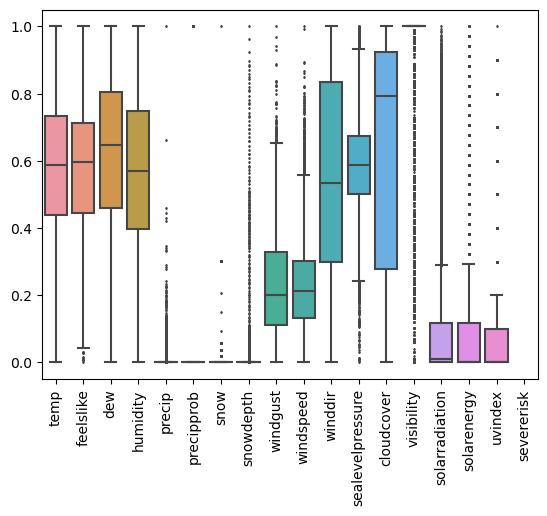

In [59]:
numeric_data = weather_data.select_dtypes("number")
numeric_data = (numeric_data - numeric_data.min()) / (numeric_data.max() - numeric_data.min())

ax = sns.boxplot(numeric_data, fliersize=1)
ax.tick_params(axis="x", rotation=90)
plt.savefig("weatherdata_boxplots_norm.png",format="png")

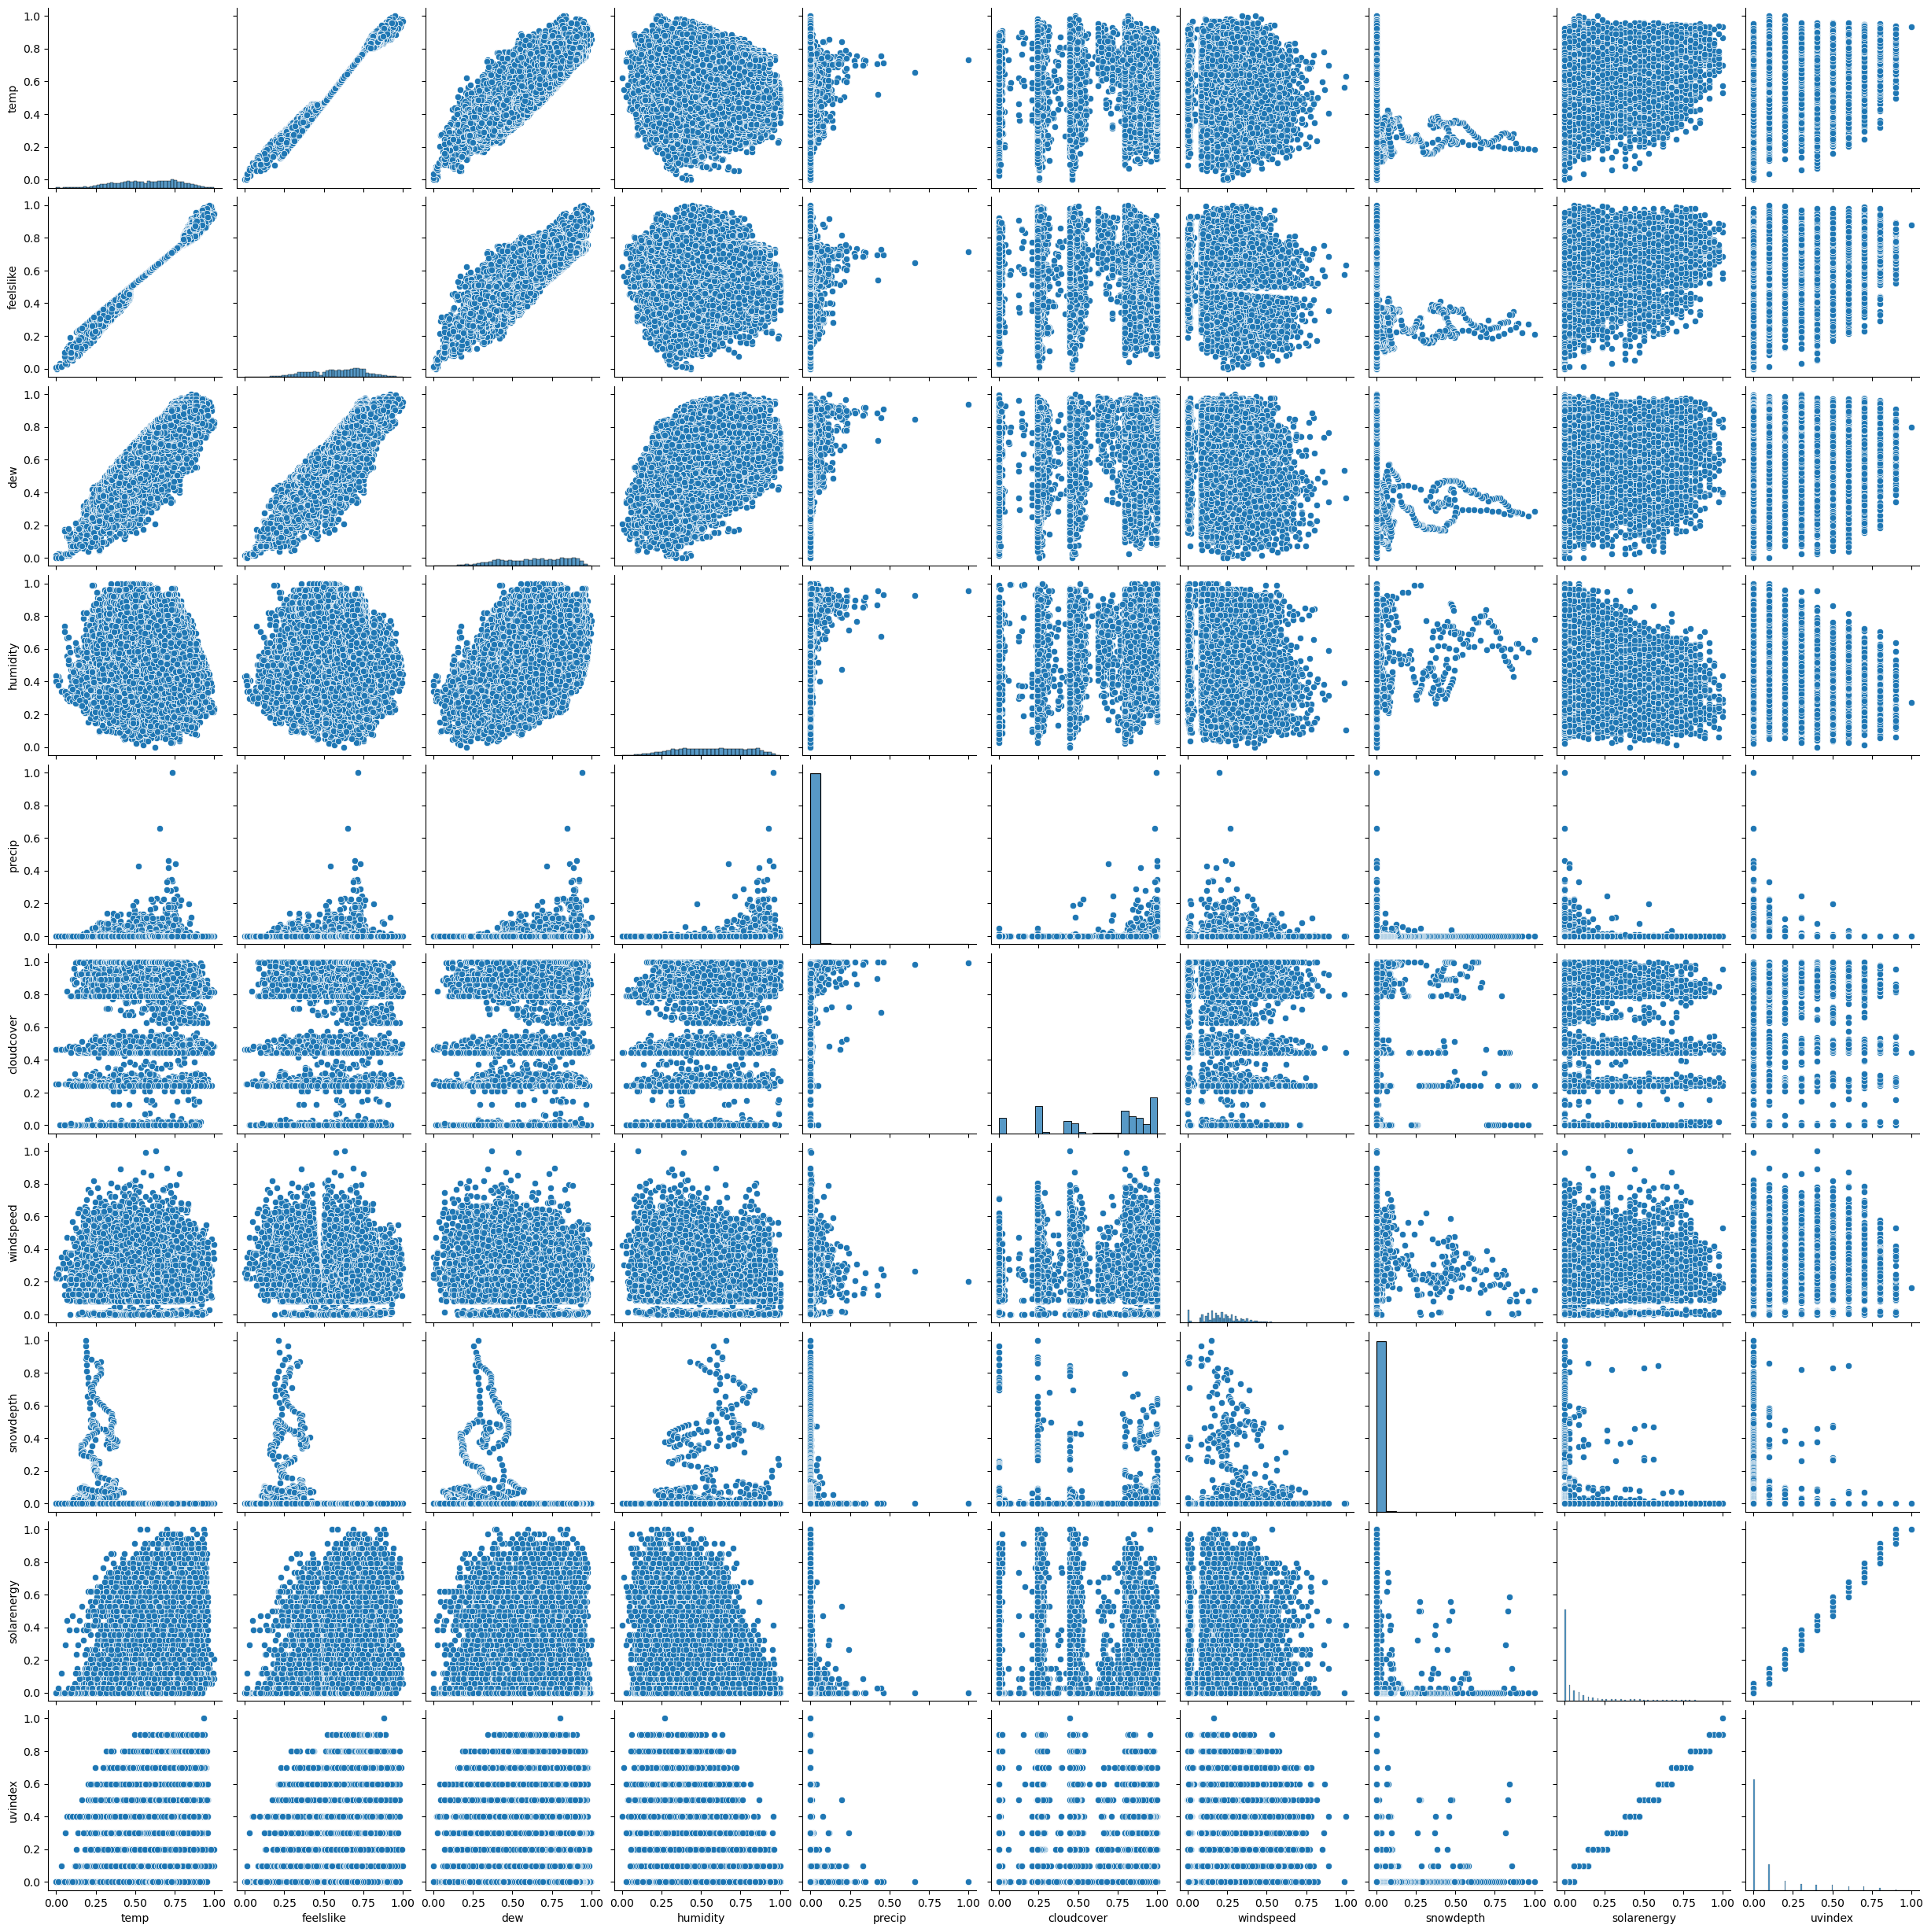

In [76]:
sns.pairplot(data=numeric_data,
             vars=['temp','feelslike','dew','humidity',
                   'precip','cloudcover','windspeed', 'snowdepth',
                   'solarenergy','uvindex',
                  ]
            )

<Axes: >

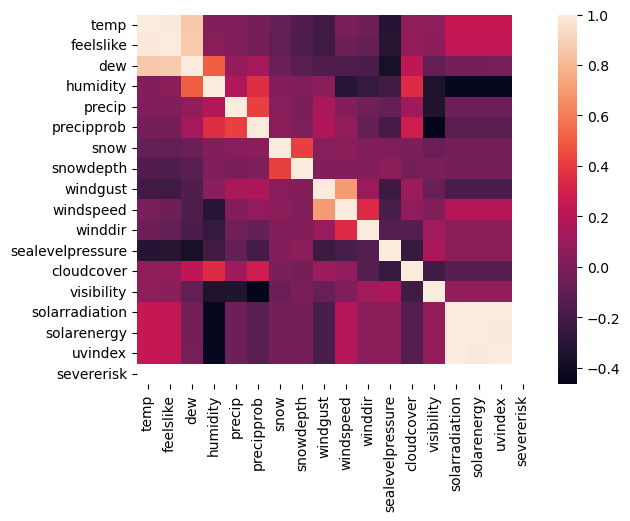

In [88]:
corrs = numeric_data.corr()
#corrs = (corrs.abs()>0.4) & (corrs<1)
sns.heatmap(corrs)

In [8]:
def add_time_features(ride_counts, time_col):
    """add a bunch of useful time-related features"""

    season_month = {12:'Winter', 1:'Winter', 2:'Winter',
                    3:'Spring', 4:'Spring', 5:'Spring',
                    6:'Summer', 7:'Summer', 8:'Summer',
                    9:'Autumn', 10:'Autumn', 11:'Autumn'}

    ride_counts['date'] = ride_counts.loc[:, time_col].dt.date

    dtfs = DatetimeFeatures(
                variables=time_col,
                features_to_extract=["year", "quarter", "month",
                                     "hour", "day_of_week", "weekend"],
                drop_original=False,
    )
    ride_counts = dtfs.fit_transform(ride_counts)
    ride_counts.columns = ride_counts.columns.str.removeprefix('time_')
    ride_counts.loc[:, 'season'] = ride_counts['month'].map(season_month)

    holidays = calendar().holidays(start=ride_counts[time_col].min(), end=ride_counts[time_col].max())
    ride_counts['is_holiday'] = pd.to_datetime(ride_counts.loc[:, 'date']).isin(holidays)
    ride_counts['is_workday'] = ~(ride_counts['weekend'] | ride_counts['is_holiday'])

    return ride_counts

In [9]:
# plot weather 'condition' against ride counts

weather_data = pd.read_csv("data/DCweather_clean.csv",
                      parse_dates=['datetime'],
                      index_col='datetime')

ride_counts_all = pd.read_csv("data/ride_counts_ALL.csv", parse_dates=['time'])
data = ride_counts_all.loc[:, ['time', 'rides_out', 'rides_in']]
data = add_time_features(data, 'time').set_index('time')
data = data.join(weather_data).asfreq("H").ffill()

In [11]:
data.groupby(["season", "condition"])['rides_out'].mean()

season  condition
Autumn  clear        448.064375
        cloudy       337.243816
        rainy        215.561129
Spring  clear        425.651509
        cloudy       338.077957
        rainy        184.393238
Summer  clear        492.989680
        cloudy       378.296345
        rainy        295.619647
Winter  clear        254.224292
        cloudy       221.358722
        rainy        111.351807
Name: rides_out, dtype: float64

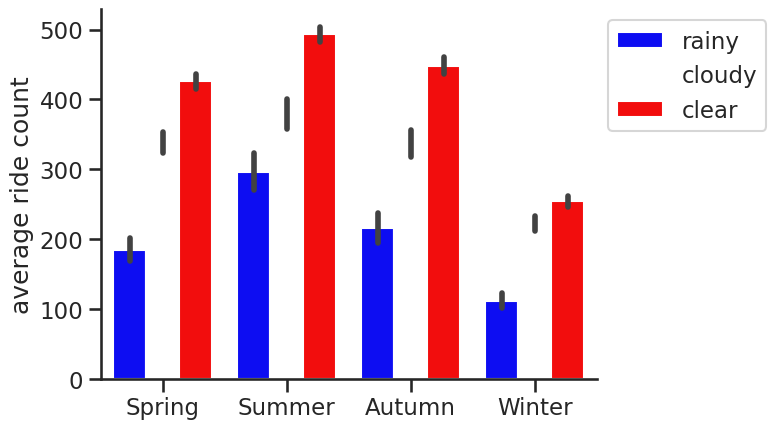

In [29]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}

fig, ax = plt.subplots()
sns.set_theme(context="talk", style="ticks", rc=custom_params)
sns.barplot(data=data, x="season", y="rides_out", hue="condition", palette={"rainy": "blue", "cloudy": "white", "clear": "red"}, saturation=0.9, ax=ax)
_ = plt.legend(bbox_to_anchor=(1, 1))
ax.set_ylabel("average ride count")
ax.set_xlabel("")
plt.savefig("figs/seasonrides_byweathercondition.png", format="png", transparent=True, bbox_inches='tight')